In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
!pip install scipy
!pip install polars
!pip install openpyxl

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import json
from scipy.stats import bootstrap
import scipy.stats as stats
import polars as pl
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.7f}'.format
np.random.seed(42)

In [3]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1)
    fig, ax = plt.subplots()
    ax.hist(res.bootstrap_distribution, bins=25)
    ax.set_title('Bootstrap Distribution')
    ax.set_xlabel(stat_label)
    ax.set_ylabel('frequency')
    plt.show()
    return res

def histo(df):
    df.hist()
    plt.tight_layout()
    plt.show()

In [4]:
column_names = ['products','helpful','funny', 'hours', 'recommended']
features = ['products','helpful','funny', 'recommended']

In [5]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [6]:
dfreco = pl.read_parquet("recommendations.parquet")#.set_index('review_id')
#dfgame = pd.read_csv("games.csv")
#dfuser = pd.read_csv("users.csv")
#dfmeta = pd.read_json('games_metadata.json', lines=False)

In [7]:
dfreco.to_pandas().describe()

app_id            helpful              funny  \
count 41,154,794.0000000 41,154,794.0000000 41,154,794.0000000   
mean     603,272.3585402          3.2025669          1.0580709   
std      472,923.2816550         46.9364857         28.6706028   
min           10.0000000          0.0000000          0.0000000   
25%      253,940.0000000          0.0000000          0.0000000   
50%      435,150.0000000          0.0000000          0.0000000   
75%      933,110.0000000          0.0000000          0.0000000   
max    2,253,290.0000000     36,212.0000000     28,109.0000000   

                   hours            user_id          review_id  
count 41,154,794.0000000 41,154,794.0000000 41,154,794.0000000  
mean         100.6022378  7,450,576.0049239 20,577,396.5000000  
std          176.1675413  4,010,685.0333110 11,880,365.8415090  
min            0.0000000          0.0000000          0.0000000  
25%            7.8000000  4,287,256.0000000 10,288,698.2500000  
50%           27.3000000  7,546,445.5000000 20,577,396.5000000  
75%           99.2000000 10,968,770.7500000 30,866,094.7500000  
max        1,000.0000000 14,306,063.0000000 41,154,793.0000000

In [8]:
dfreco.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


In [9]:
df = dfreco.to_pandas().groupby('user_id').agg({'helpful':'sum', 'funny':'sum', 'app_id': 'nunique', 'is_recommended':'sum', 'hours':'sum'}).rename(columns={'app_id': 'products', 'is_recommended':'recommended'})


In [10]:
from sklearn.decomposition import PCA

X = df[column_names].values

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]
df['single_pca_sort'] = df.single_pca.abs()

In [11]:
pd.DataFrame(pca.components_, columns=column_names).style.set_caption("Feature Importance with Hours")

In [12]:
from sklearn.decomposition import PCA

X = df[features].values

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]
df['single_pca_sort'] = df.single_pca.abs()


In [13]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance without Hours")

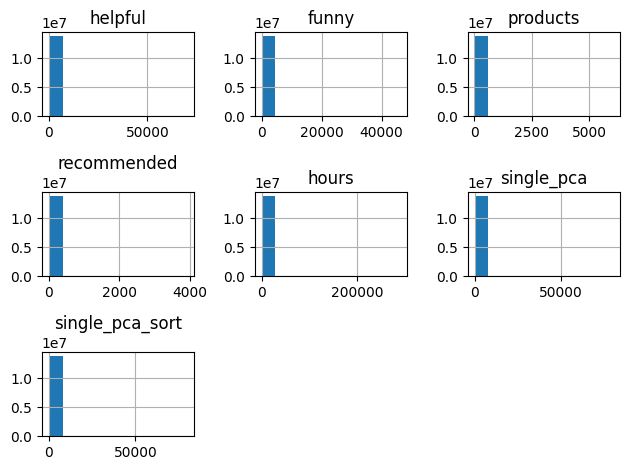

In [14]:
histo(df)
df = df[(df.helpful > 0)&(df.funny > 0)&(df.recommended > 0)&(df.recommended < df.products)&(df.products>10)]

df['helpful_rat'] = df.helpful / df.products
df['funny_rat'] = df.funny / df.products
df['recommended_rat'] = df.recommended / df.products
df['hours_rat'] = df.hours / df.products

df = df[df['single_pca_sort'] >= np.percentile(df['single_pca_sort'].values, 95)]

In [15]:
df.describe()

helpful          funny       products    recommended  \
count 14,411.0000000 14,411.0000000 14,411.0000000 14,411.0000000   
mean   1,802.1450281    515.1260842     78.6354174     60.7531053   
std    2,476.1002484  1,035.1345559    142.7658154    100.8037910   
min      278.0000000      2.0000000     11.0000000      1.0000000   
25%      822.0000000     92.0000000     22.0000000     17.0000000   
50%    1,114.0000000    234.0000000     42.0000000     33.0000000   
75%    1,796.5000000    583.0000000     85.0000000     68.0000000   
max   70,096.0000000 46,186.0000000  6,045.0000000  3,920.0000000   

                hours     single_pca  single_pca_sort    helpful_rat  \
count  14,411.0000000 14,411.0000000   14,411.0000000 14,411.0000000   
mean    3,138.5704948  1,866.1255069    1,866.1255069     46.0394718   
std     4,690.6334289  2,508.2388381    2,508.2388381     64.8118302   
min         3.1000000    679.5397599      679.5397599      0.4546875   
25%     1,277.0500000    853.8022989      853.8022989     14.9868398   
50%     2,286.7000000  1,161.1603046    1,161.1603046     29.0606061   
75%     3,831.6500000  1,871.2231903    1,871.2231903     55.1166038   
max   290,694.2000000 79,834.0461647   79,834.0461647  2,116.0434783   

           funny_rat  recommended_rat      hours_rat  
count 14,411.0000000   14,411.0000000 14,411.0000000  
mean      16.2091224        0.7914095     64.3556991  
std       37.1375667        0.1610362     56.7854985  
min        0.0061350        0.0084034      0.2583333  
25%        1.6371473        0.7142857     26.8604779  
50%        4.9473684        0.8333333     48.3647059  
75%       15.3974359        0.9142857     83.4215686  
max      999.7692308        0.9988675    889.8714286

In [16]:
X = df[features].values
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X)
scores = iso.decision_function(X)

df["iso"] = outliers
df["iso_score"]  = scores
df['type'] = df['iso'].apply(lambda x: "Outlier" if x == -1 else "Inlier")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14411 entries, 1209 to 14305387
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   helpful          14411 non-null  int64  
 1   funny            14411 non-null  int64  
 2   products         14411 non-null  int64  
 3   recommended      14411 non-null  int64  
 4   hours            14411 non-null  float64
 5   single_pca       14411 non-null  float64
 6   single_pca_sort  14411 non-null  float64
 7   helpful_rat      14411 non-null  float64
 8   funny_rat        14411 non-null  float64
 9   recommended_rat  14411 non-null  float64
 10  hours_rat        14411 non-null  float64
 11  iso              14411 non-null  int64  
 12  iso_score        14411 non-null  float64
 13  type             14411 non-null  object 
dtypes: float64(8), int64(5), object(1)
memory usage: 1.6+ MB


In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
sns_order = ['Outlier', 'Inlier']

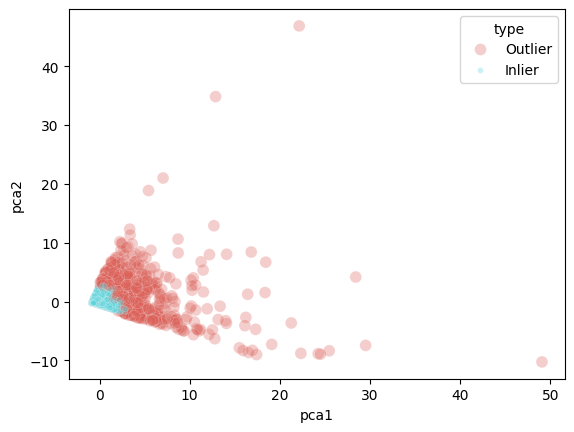

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="pca1", 
    y="pca2", 
    hue="type",
    hue_order = sns_order,
    legend=True,
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

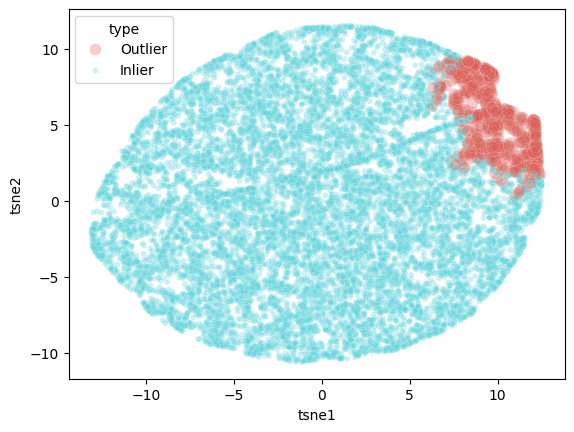

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X)

df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="tsne1", 
    y="tsne2", 
    hue="type",
    hue_order = sns_order,
    legend="full",
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

In [20]:
df_outliers = df[df["iso"] == -1]
df_outliers = df_outliers.sort_values(by='single_pca_sort', ascending=False)#['products','helpful','funny', 'hours', 'recommended'], ascending=False)
df_outliers.reset_index(inplace=True)
df_outliers.index = np.arange(1, len(df_outliers)+1)
df_outliers.head()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_outliers.style.format(precision=2))

In [23]:
import datetime
data1 = datetime.datetime(2003, 1, 1, 0, 0, 0) #First Possible Launch of Steam
data2 = datetime.datetime.now() 

diff = data2 - data1
hours = diff.days * 24 + diff.seconds // 3600

In [24]:
df_outliers = df_outliers[df_outliers.hours <= hours]

In [26]:
print(f'Original user count: {dfreco.to_pandas().user_id.nunique()}')
print(f'User candidate count: {len(df)}')
print(f'Anomaly user count: {len(df_outliers)}')

Original user count: 13781059
User candidate count: 14411
Anomaly user count: 719


In [27]:
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 719 entries, 1 to 721
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          719 non-null    int64  
 1   helpful          719 non-null    int64  
 2   funny            719 non-null    int64  
 3   products         719 non-null    int64  
 4   recommended      719 non-null    int64  
 5   hours            719 non-null    float64
 6   single_pca       719 non-null    float64
 7   single_pca_sort  719 non-null    float64
 8   helpful_rat      719 non-null    float64
 9   funny_rat        719 non-null    float64
 10  recommended_rat  719 non-null    float64
 11  hours_rat        719 non-null    float64
 12  iso              719 non-null    int64  
 13  iso_score        719 non-null    float64
 14  type             719 non-null    object 
 15  pca1             719 non-null    float64
 16  pca2             719 non-null    float64
 17  tsne1            719 

In [28]:
df_outliers.describe()

user_id        helpful          funny      products  \
count        719.0000000    719.0000000    719.0000000   719.0000000   
mean   8,187,881.9012517  7,962.6954103  2,422.9401947   381.0236439   
std    3,834,656.9512332  7,610.6768948  3,537.8315834   482.0273640   
min        1,239.0000000    601.0000000      4.0000000    11.0000000   
25%    5,245,245.0000000  3,048.0000000    399.5000000    82.0000000   
50%    8,593,707.0000000  6,102.0000000  1,234.0000000   281.0000000   
75%   11,526,784.0000000 10,300.0000000  3,602.0000000   500.5000000   
max   14,283,059.0000000 70,096.0000000 46,186.0000000 6,045.0000000   

        recommended          hours     single_pca  single_pca_sort  \
count   719.0000000    719.0000000    719.0000000      719.0000000   
mean    280.9916551  6,856.4756606  8,320.2254620    8,320.2254620   
std     323.9716234  8,038.5767836  7,586.4205029    7,586.4205029   
min       1.0000000    141.1000000    685.9094073      685.9094073   
25%      69.0000000  2,858.2500000  3,687.8023509    3,687.8023509   
50%     216.0000000  4,894.0000000  6,618.5330326    6,618.5330326   
75%     369.0000000  7,861.5000000 10,697.6859041   10,697.6859041   
max   3,920.0000000 73,729.9000000 79,834.0461647   79,834.0461647   

        helpful_rat   funny_rat  recommended_rat   hours_rat         iso  \
count   719.0000000 719.0000000      719.0000000 719.0000000 719.0000000   
mean     90.3821232  52.4750243        0.8023868  39.9224428  -1.0000000   
std     183.9717168 116.0913683        0.1778696  52.5723658   0.0000000   
min       0.4546875   0.0083160        0.0084034   0.8693522  -1.0000000   
25%       8.3380240   0.8103952        0.7298649  10.8742563  -1.0000000   
50%      29.6405694   4.4515050        0.8440860  22.4123167  -1.0000000   
75%      89.3553556  41.9963803        0.9328526  49.4377622  -1.0000000   
max   2,116.0434783 999.7692308        0.9988675 512.0131944  -1.0000000   

        iso_score        pca1        pca2       tsne1       tsne2  
count 719.0000000 719.0000000 719.0000000 719.0000000 719.0000000  
mean   -0.0763759   4.1490255   1.2780087   9.9536715   5.3041787  
std     0.0578086   4.1205468   4.0317322   1.5732001   2.1793551  
min    -0.2546112   0.0827984 -10.2673667   6.1748557   0.2910270  
25%    -0.1158702   1.9169312  -1.3222910   8.7319546   3.5203618  
50%    -0.0646266   3.1912021   1.3525271   9.7464972   5.1906419  
75%    -0.0283529   4.7280131   3.2404268  11.5892930   7.1901929  
max    -0.0000260  49.0668478  46.8330080  12.4152193   9.3949242

In [29]:
df_outliers = df_outliers.sort_values(by='single_pca_sort', ascending=False)#['products','helpful','funny', 'hours', 'recommended'], ascending=False)
df_outliers.reset_index(inplace=True)
df_outliers.index = np.arange(1, len(df_outliers)+1)
df_outliers.head()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_outliers.style.format(precision=2))

In [30]:
df_outliers.to_excel('outlier_users.xlsx')